In [1]:
import numpy as  np
import scipy.io as  l
import os, sys
top_dir = os.getcwd().split('v4cnn')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')

import xarray as xr
import d_misc as dm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline     

This function will do our permuting of cell responses over position.

In [59]:
def permute_unit(unit):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    for x in range(len(unit.coords['x'])):
        unit[x,:] = np.random.permutation(unit[x,:].values)
    return unit 
def permute_unit_array(unit):
    for x in range(np.shape(unit)[1]):
        unit[:,x] = np.random.permutation(unit[:,x])
    return unit 

The function below is the core of the TI measurement.

It measures the fit of a unit's matrix $R$ of responses over position and stimuli, that can be accounted for by the outer product of a receptive field $\vec{f}$, and  stimuli response profile $\vec{s}$. 
$$ R = \vec{f} \otimes \vec{s} $$
We do this using SVD, for the $m$ shapes, and $n$ positions where typically $m>n$. We construct an $m \ x \ n$ matrix $R$

For which we decompose using SVD:
$$ R = U \Sigma V $$

$U$ is $m \ x \ n$, its columns are eigenvectors of $R$, and the 1st column is the least squares estimate of $\vec{s}$.

V is $n \ x \ n$, its rows are eigenvectors of $R$, and the first column is a least squares estimate of $\vec{f}$.

$\Sigma$ is $n \ x \ n$ where $\Sigma_{ii}=\sigma_i$ are the sorted singular values of $R$, $\sigma_1$ is the smallest possible value of  $\sqrt{ \sum  (R - \vec{f} \otimes \vec{s})^2}$

Finally we take as our measure of fit to the TI model we will call TIA:
$$\frac{\sigma_1^2}{\sum \sigma_i^2}$$

In [92]:
def measure_TIA(unit):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    tot_var = (unit**2).sum()
    s = np.linalg.svd(unit.values, compute_uv=False)
    return (s[0]**2)/np.sum(s**2)
def measure_TIA_array(unit):
    tot_var = np.sum((unit**2))
    s = np.linalg.svd(unit, compute_uv=False)
    return (s[0]**2)/np.sum(s**2)

Unfortunately TIA has problems with overfitting.
For example if we take response that has no translation invariance, i.e. each column is orthogonal TIA will not give it a score of 0.

In [4]:
unit = np.eye(5)*2
print(unit)
print('TIA = ' + str(measure_TIA_array(unit)))

[[ 2.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  2.]]
TIA = 0.2


It instead gives TIA of 0.2, why is this?

In [5]:
print('The singular values of our unit:')
print(np.linalg.svd(unit, compute_uv=False))

The singular values of our unit:
[ 2.  2.  2.  2.  2.]


Because the SVD guarantees only that $$\sigma_1 \ge \dots \ge \sigma_n$$ and in the above case $$\sigma_1 = \dots = \sigma_n$$ where $\sigma_1$ accounts for $\frac{1}{n}$ of the variance of a matrix, where $n$ is the number of positions, the smallest it possibly can be. This is uniquely the case where all columns of our matrix have equal length and are orthogonal.
In this case $TIA>=\frac{1}{n}$, our metric cannot reach 0. In addition TIA depends on the number of positions measured another severe shortcoming.

To correct for this in general we can try to figure out, for the type of matrices we are dealing with, what $F$ is where $TIA>=F$

Then we get a normalized value $$TIN = \frac{TIA-F}{(1-F)}$$

If for example we take $F = \frac{1}{n}$ we are guranteed that TIN over all possible response matrices will range between 0, and 1. Lets check for our previous matrix: 

In [6]:
unit = np.eye(5)
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
TIN = (TIA-F)/((1-F))
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))

TIA = 0.2
TIN = 0.0


<h4>Non-Uniform RF</h4>

While $F = \frac{1}{n}$ works in the previous case lets look at the case where we know our matrix does not have column vectors of equal length i.e. a non-uniform RF. Here we are essentially trying to remove receptive field size as a factor in TI i.e. just because two cells have different RF sizes, doesn't mean one should get better TI:

In [9]:
unit = np.zeros((4,4))
unit[:,1] = 1
unit[:,2] = [1,-1,1,-1]

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2,0))

Unit responses:
[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
RF:
[ 0.  4.  4.  0.]


In this case the cell has a non-uniform RF.

Keep in mind again the columns are orthogonal so intuitively we should expect a translation invariance of 0.

What is our measure of TIA and TIN where $F = \frac{1}{n}$, for this response matrix?

In [10]:
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
print('F=' + str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False))

F=0.25
TIA = 0.5
TIN = 0.333333333333
The singular values=
[ 2.  2.  0.  0.]


Terrible! It seems a non-translation invariant cell can take on translation invariance simply with a non-uniform receptive field, in this case a compact receptive field. 

Even if our columns are orthogonal $\sigma_1$ will simply equal the magnitude of the greatest response position, or the center of the RF.

In the case of all response matrices with non-uniform RF's what F do we need?
$$F = \frac{max_i(\sum\limits_{j=1}^m R_{i,j}^2)}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$

The variance of the position with the greatest variance divided by the total variance. 

Lets see how it works:

In [11]:
print(unit)
TIA = measure_TIA_array(unit)
F = max(np.sum(unit**2,0))/np.sum(unit**2)
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))

[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
TIA = 0.5
TIN = 2.22044604925e-16


Nice! The intuition behind this correction is that if we only know the length of each column vector, the direction of those vectors is still free to vary. With direction freely varying but length fixed vectors, what is the minimal singular value they could take on? It is the case where all columns are orthogonal to each other, and in this case the principal component will take on the direction of the longest vector, and will account for only its variance (because all other columns are orthogonal to it).
Now lets try to add on one more constraint the SR

Response Matrix:
[[ 10.   0.]
 [  0.   2.]]
Our estimated stimuli profile
[[ 1.]
 [ 0.]]
Our estimated receptive field
[ 1.  0.]
Our singular values
[ 10.   2.]
Our estimated TI response
[[ 10.   0.]
 [  0.   0.]]


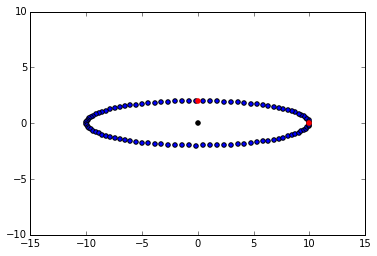

In [57]:

pi = np.pi
a = np.eye(2)*np.array([10 , 2])
print('Response Matrix:')
print(a)
theta = np.linspace(0,2*pi,100)
circle = np.array([np.cos(theta), np.sin(theta)]).T
res = np.dot(circle, a)
plt.scatter(res[:,0],res[:,1])
plt.scatter(0,0, color='k')
plt.scatter(a[:,0],a[:,1],color='r')
plt.axis('equal')
u,s,v = np.linalg.svd(a)
print('Our estimated stimuli profile');print(u[:,0].reshape(2,1))
print('Our estimated receptive field');print(v[0,:])
print('Our singular values');print(s)
print('Our estimated TI response');print(np.dot(u[:,0].reshape(2,1), v[0,:].reshape(1,2))*s[0]) 

Above I demonstrated this inuition where in red I show the two vectors composing my orthogonal response matrix with a non-uniform RF, and in blue I show the covariance (w/out mean subtracted) for unit vectors at the same angle as the blue with reference to the black, clearly the most covariance is to be found in the direction of the longest vector in my orthogonal matrix. The direction of my longest vector does in fact become my 1st estimated stimuli profile, and it is scaled exactly by its length.

<h4>Non-uniform SP</h4>
Now lets see what happens when our SP constrains the dimensionality of our matrix, this reflects the possible case where our unit only responds strongly to a subset of the stimuli.

In [73]:
unit = np.zeros((3,3))
unit[0,0] = 1
unit[1,1] = 0.5**0.5
unit[0,1] = 0.5**0.5
unit[1,2] = 1

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2, 0))
print('SP')
print(np.sum(unit**2, 1))

Unit responses:
[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
RF:
[ 1.  1.  1.]
SP
[ 1.5  1.5  0. ]


In [74]:
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0)])/np.sum(unit**2)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)      

F=0.333333333333
TIA = 0.666666666667
TIN = 0.5
The singular values=
[ 2.  1.  0.]


Our original motivation for F was that it would take on the minimal value a class of matrices under study could take. In this case we are studying matrices with a particular RF and SP. For this matrix I posit for this RF and SP is the minimal possible value TIA can take on (for this dimensionality this is the lowest covariance two vectors orthogonal and one 45 degrees from both), which as you can see is .66, yet F is calculated as 0.33. 

We run into a problem attempting to find what F in general should be... when we know the RF, we fully determine the length of our column vectors, and the information from the SP constrains their direction. In the above case the compact SP constrains our column vectors to only point along the first two dimensions. Thus our assumption of orthogonality gives a much lower min TIA, then is actually the case.

Our trick before was to find the minimal value of TIA by assuming orthogonality of our column vectors, but for some SF's this is not possible. Determining the minimal TIA for vectors that are not correlated, amounts to finding the arrangement of vectors with an RF and SP that minimizes R's covariance. 

One way around this is to assume we can achieve orthogonality and follow this assumption to its logical conclusion given our knowledge of the RF and SP. 

Lets start with the fact that $A$ and $A^T$ have the same singular values:

In [80]:
a = np.random.normal(size=[10,5])
u,s,v = np.linalg.svd(a);print(s)
u,s,v = np.linalg.svd(a.T);print(s)

[ 4.77037067  4.26483488  2.39404385  2.34359505  1.88812591]
[ 4.77037067  4.26483488  2.39404385  2.34359505  1.88812591]


keeping the fantasy of orthogonality in mind we look at $A$ and $A^T$ and know the greatest singular value will be the highest variance of the columns of either. 

$$F = \frac{max(max_i(\sum\limits_{j=1}^m \ R_{i,j}^2),max_j(\sum\limits_{i=1}^n R_{i,j}^2))}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$

Keep in mind this gives a potentially conservative estimate of TIA as for some RF and SP's their forced correlation could make their floor TI much higher. Lets see how it works

In [75]:
unit = np.zeros((3,3));unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0),np.sum(unit**2,1)])/np.sum(unit**2)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)   

[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
F=0.5
TIA = 0.666666666667
TIN = 0.333333333333
The singular values=
[ 2.  1.  0.]


Here we see our F gets closer to the true F (in this case TIA) but doesn't quite make it. Thus our current F as it is will give preference to units with sparser responses over shapes.
Another way is to estimate F, we randomly draw from vectors with the RF and SP, then take the minimal TIA. 
One initial try might be to permute the columns, then take the mean, or min as our F.

In [79]:
unit = np.zeros((3,3));unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1
n_permute = 10000
tias = []
print(unit)
for ind in range(n_permute):
    tias.append(measure_TIA_array(permute_unit_array(unit)))
print('F estimate min(TIAS) :' + str(min(tias)))
print('F estimate mean(TIAS) :' + str(np.mean(tias)))
print('F estimate median(TIAS) :' + str(np.median(tias)))
unit[:,:] = 0
unit[1,:] = 1
print(unit)
for ind in range(n_permute):
    tias.append(measure_TIA_array(permute_unit_array(unit)))
print('F estimate min(TIAS) :' + str(min(tias)))
print('F estimate mean(TIAS) :' + str(np.mean(tias)))
print('F estimate median(TIAS) :' + str(np.median(tias)))

[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
F estimate min(TIAS) :0.569035593729
F estimate mean(TIAS) :0.669254697106
F estimate median(TIAS) :0.666666666667
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]]
F estimate min(TIAS) :0.333333333333
F estimate mean(TIAS) :0.648410681886
F estimate median(TIAS) :0.666666666667


Uh oh! First of all our min sampled TIA, is lower than the true minimal TIA, and our mean TIA is higher but our median is actually perfect but this is an artifiact. As you can see I try the same procedure on anothe response, and get nowhere near the true F, which is in both cases because shuffling changes the dimensionality of my matrix.
So what to do!? I'm not sure, to estimate stochastically we need to draw from matrices that satisfy the SP and RF (the simplest way would be to randomly flip signs, but this doesn't draw from all possible matrics). And to find F otherwise we need a method that finds the matrix with the same RF and SF that minimizes covariance, unfortunately the equation we must satisfy is a sum of squared entries in our matrix, so is undetermined, i.e. each entry could have been positive or negative, and still satisfy the equation.
Well lets see how our methods limited as they are compare on real data.

<h4>Best possible and worst possible TI units</h4>
Here I am making two pathological units, min_ti has 0 translation invariance, it is a fourier basis, and max_ti_unit

In [15]:
min_ti_unit = np.concatenate([np.imag(np.fft.rfft(np.eye(5)))[:,1:], np.real(np.fft.rfft(np.eye(5)))[:,1:]], axis =1)
min_ti_unit = np.concatenate([min_ti_unit, np.zeros((51,4))])
the_nans = (np.nan*np.ones((np.shape(min_ti_unit)[0],1)))
min_ti_unit = np.concatenate([min_ti_unit, the_nans], 1)
max_ti_unit = np.tile(min_ti_unit[:,0],(5,1)).T
min_ti_unit = np.expand_dims(min_ti_unit.T, 0)
min_ti_unit = xr.DataArray(min_ti_unit, dims=['unit','x','shapes'])
max_ti_unit = np.expand_dims(max_ti_unit.T, 0)
max_ti_unit = xr.DataArray(max_ti_unit, dims=['unit','x','shapes'])

Here we can look at the values of these pathological cells, here rows are positions, and columns 'shapes'. Note the first just has the same response over each position, and the second has an orthogonal basis function of first sines then cosines. In this case the cells only respond to the first couple shapes.

In [16]:
print('Perfect TI')
print(np.round(max_ti_unit[0,:,:10],3).values)
print('Perfectly terrible TI')
print(np.round(min_ti_unit[0,:4,:10],3).values)

Perfect TI
[[ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]]
Perfectly terrible TI
[[ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.588  0.951 -0.951  0.588  0.     0.     0.     0.     0.   ]
 [ 1.     0.309 -0.809 -0.809  0.309  0.     0.     0.     0.     0.   ]
 [ 1.    -0.809  0.309  0.309 -0.809  0.     0.     0.     0.     0.   ]]


Now lets load up the V4 cells, and concatenate them with our artificial cells at the top of the unit by position by shape stack

In [157]:
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()

v4 = v4.transpose('unit', 'x', 'shapes') 


Lets look at the histogram of responses for the V4 cells.

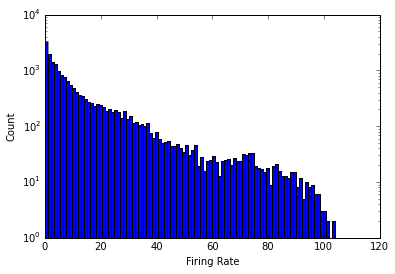

In [158]:
all_v4 = v4.values.ravel()
all_v4 = all_v4[~np.isnan(all_v4)]
_ = plt.hist(all_v4,log=True, bins=100);plt.xlabel('Firing Rate');plt.ylabel('Count')

Looks good, seem to be the raw responses, without the mean subtracted.
Now lets tack our pathological cells on to the V4 data set, and subtract the mean of the shapes at each position.

In [110]:
v4 = xr.concat([min_ti_unit, max_ti_unit, v4], dim='unit')
v4 = v4 - v4.mean('shapes')

Now lets try out all of our discussed methods of finding F, and see how they compare.

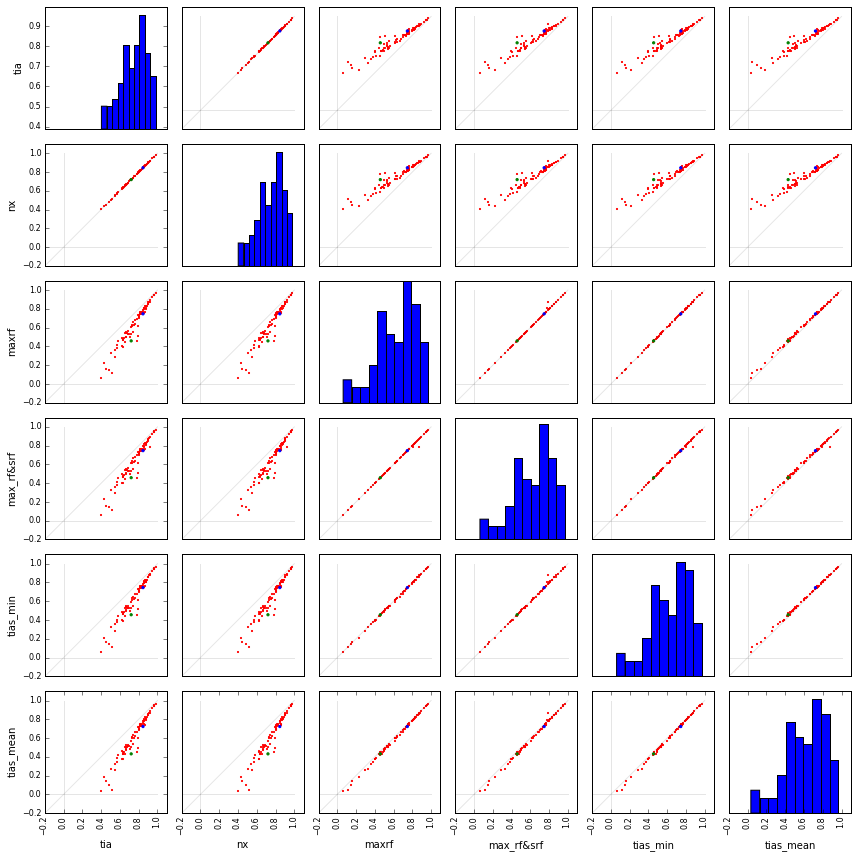

In [115]:

#f = 0
tia = np.array([measure_TIA(unit) for unit in v4])
#f = 1/n_x
n_x = np.array([cell.dropna('x', 'all').dropna('shapes', 'all').shape[0] for cell in v4])
f = 1/n_x
tin_f_nx = (tia-f)/(1-f)
#f = max(rf)/tot_var
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
tot_var = (v4**2).sum(['shapes','x'])
f = (max_rf_var/tot_var).values
tin_f_maxrf = (tia-f)/(1-f)
#f = max(max(rf), max(sf))
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
max_srf_var = (v4.dropna('shapes', 'all')**2).sum('x').max('shapes')
max_both = xr.concat([max_rf_var,max_srf_var], dim='c').max('c')
f = max_both/tot_var
tin_f_max_rf_srf = ((tia-f)/(1-f)).values
#f = mean(TI(cell resp permuted))
n_perms = 20
tias_mean = [] 
tias_min = [] 
for unit in v4:
     unit = unit.dropna('x', 'all').dropna('shapes', 'all')
     all_perm_tia = [measure_TIA(permute_unit(unit)) for ind in range(n_perms)]
     tias_mean.append(np.mean(all_perm_tia))
     tias_min.append(np.min(all_perm_tia))

f = np.array(tias_mean)
tin_f_tias_mean = (tia-f)/(1-f)

f = np.array(tias_min)
tin_f_tias_min = (tia-f)/(1-f)

tins_lst = np.array([tia, tin_f_nx, tin_f_maxrf, tin_f_max_rf_srf, tin_f_tias_min, tin_f_tias_mean]).T
tins_nm = ['tia', 'nx', 'maxrf', 'max_rf&srf', 'tias_min', 'tias_mean']
tins = pd.DataFrame(tins_lst, columns=tins_nm)

from pandas.tools.plotting import scatter_matrix
axes = scatter_matrix(tins[2:], alpha=1, figsize=(12, 12),s=5, color='r')
for i, axes1 in enumerate(axes):
    for j, ax in enumerate(axes1):
        if i!=j:
            ax.plot([-1,1],[-1,1], alpha=0.1, color='k');
            ax.plot([-1,1],[0,0],alpha=0.1, color='k');
            ax.plot([0,0], [-1,1],alpha=0.1, color='k');

            ax.set_xlim(-0.2,1.1);ax.set_ylim(-0.2,1.1);
            ax.scatter(tins.loc[:1].values[:,j],tins.loc[0:1].values[:,i], color=['b','g'], s=5)
        else:
            ax.set_xlim(-0.2,1.1);            
_ = plt.tight_layout()
_=plt.show()


At a glance it would seem F=1/n doesn't do much, max rf does about the same as anyting else, except dividing max rf and sf seems to change the value of one of our cells a little bit. 
One problem we quickly note is that using TIAs mean does give us a negative value for our perfectly translation invariant unit.
Now our worse fear is that our TI is mainly being driven by units that are sparse over shape. Let look at real units and see if we can find at least a correlation to support this.

(80, 56)
(80,)
r = 0.210210389579
r = 0.143594152023


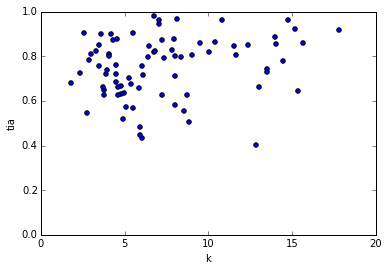

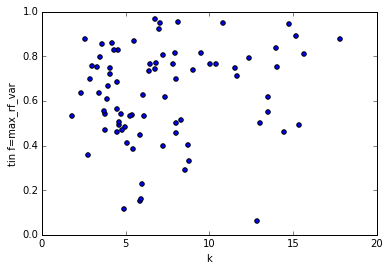

In [127]:
def kurtosis(da):
    da = da.dropna('shapes')
    da = da.transpose('shapes','unit')
    mu = da.mean('shapes')
    sig = da.reduce(np.nanvar, dim='shapes')
    k = (((da - mu)**4).sum('shapes',skipna=True)/da.shapes.shape[0])/(sig**2)
    return k
#lets find kurtosis of our SP
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()
v4 = v4.transpose('unit', 'x', 'shapes') 
v4 = v4 - v4.mean('shapes')
sp = v4.var('x')
k = kurtosis(sp)

#f = 0
tia = np.array([measure_TIA(unit) for unit in v4])
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
tot_var = (v4**2).sum(['shapes','x'])
f = (max_rf_var/tot_var).values
tin_f_maxrf = (tia-f)/(1-f)
print(sp.shape)
print(tin_f_maxrf.shape)
plt.scatter(k, tia);plt.ylim(0,1);plt.ylabel('tia');plt.xlabel('k');
print('r = ' +  str(np.corrcoef([k,tia])[0,1]))

plt.figure()
plt.scatter(k, tin_f_maxrf);plt.ylim(0,1);plt.ylabel('tin f=max_rf_var');plt.xlabel('k');
print('r = ' +  str(np.corrcoef([k,tin_f_maxrf])[0,1]))

There is some correlation but not alot in part because of that outlier.

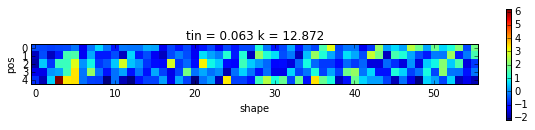

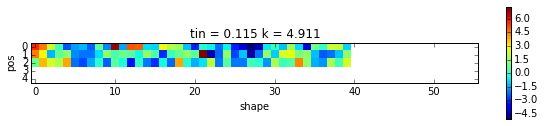

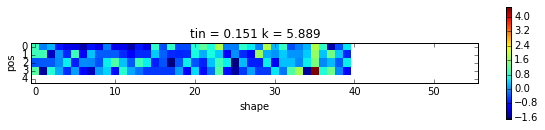

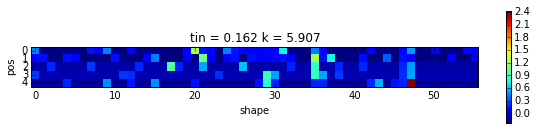

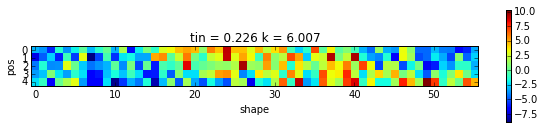

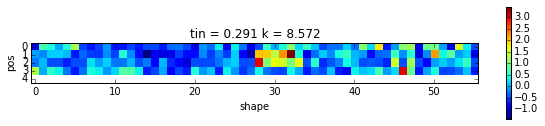

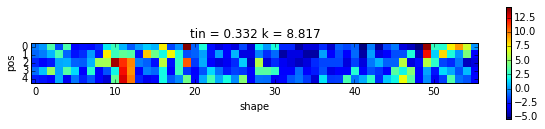

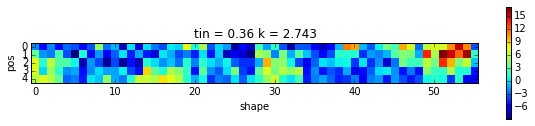

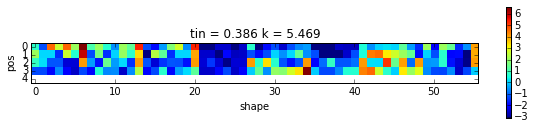

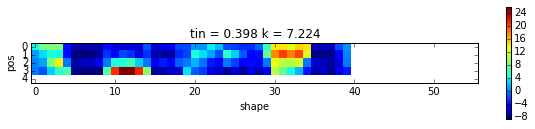

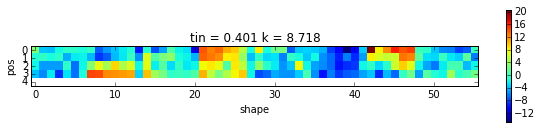

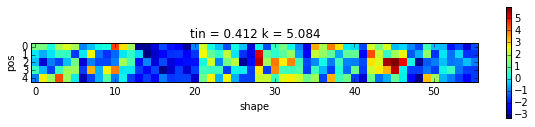

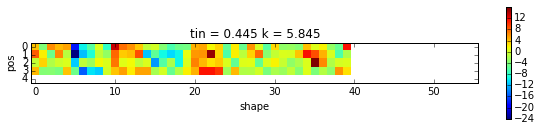

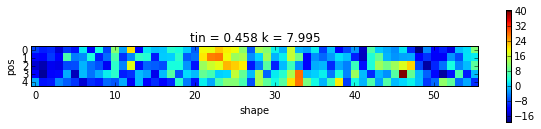

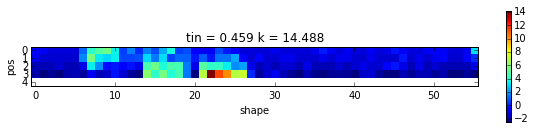

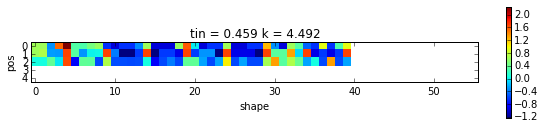

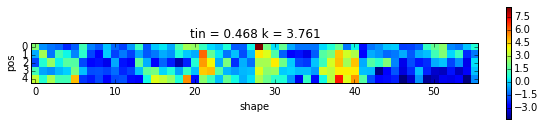

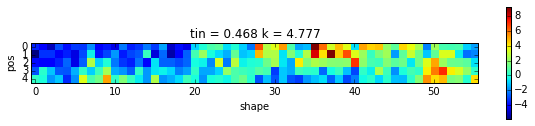

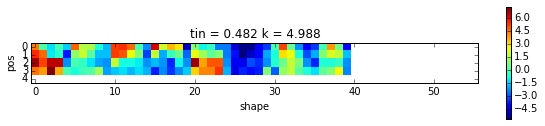

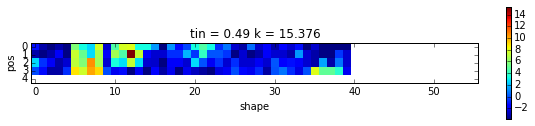

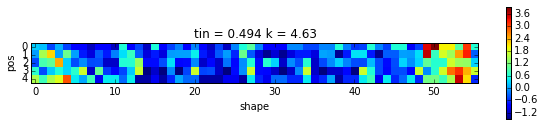

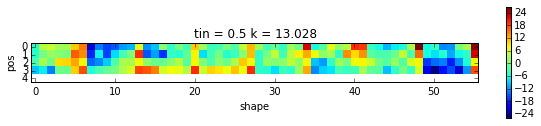

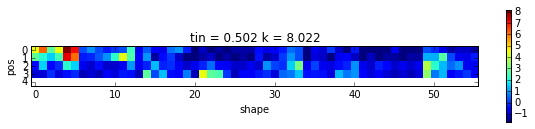

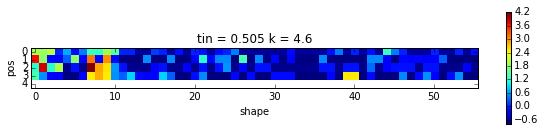

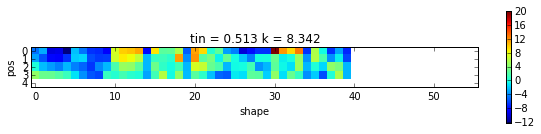

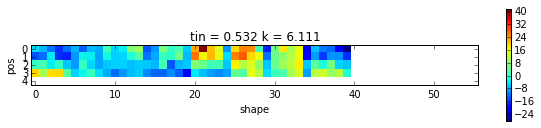

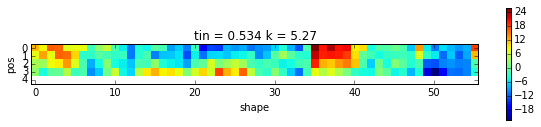

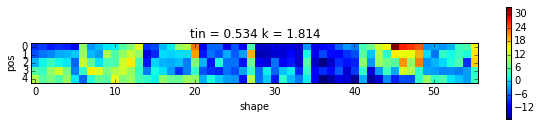

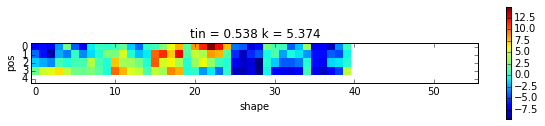

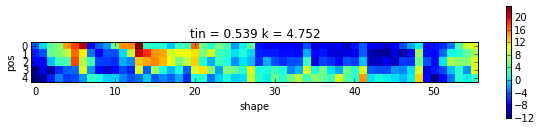

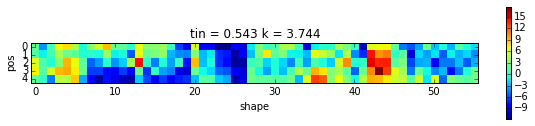

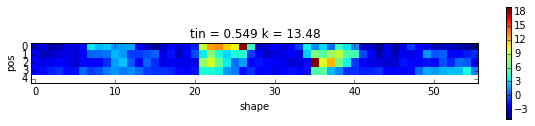

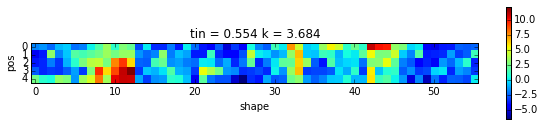

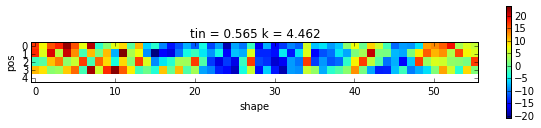

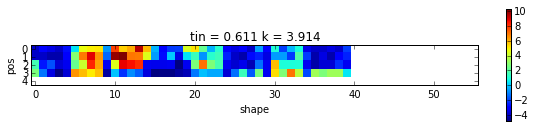

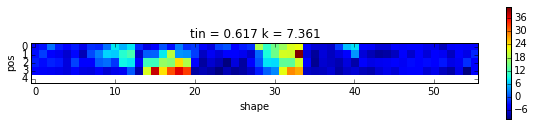

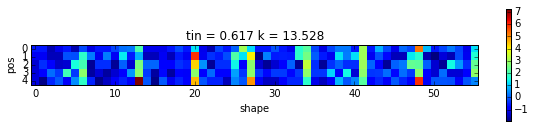

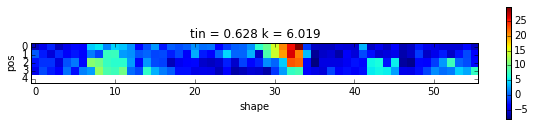

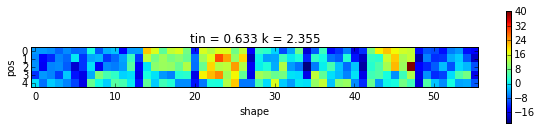

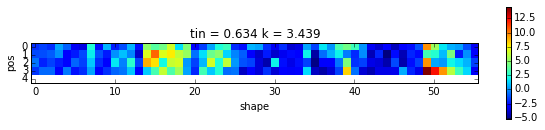

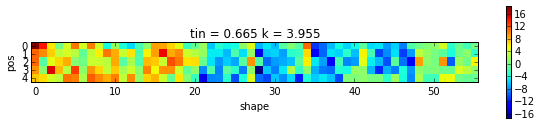

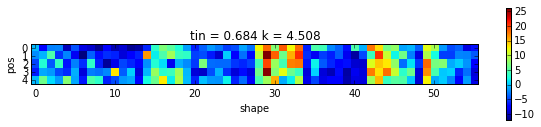

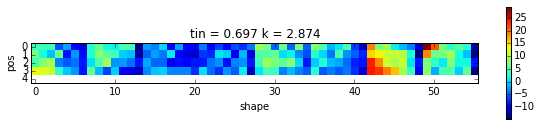

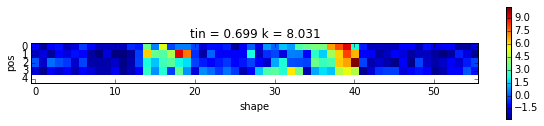

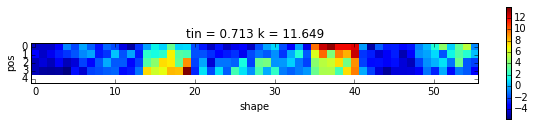

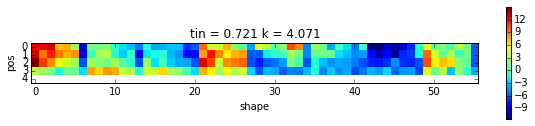

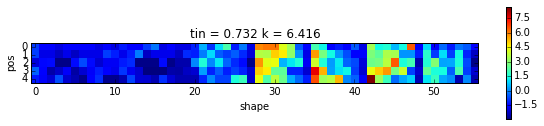

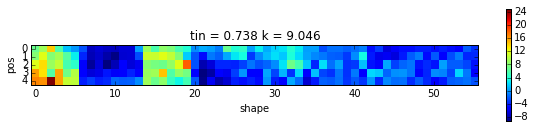

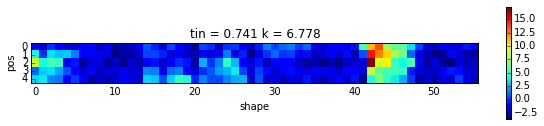

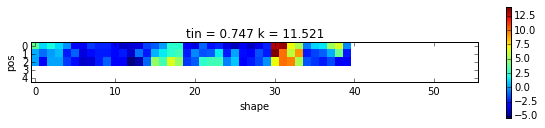

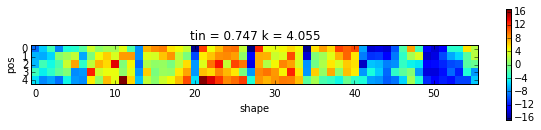

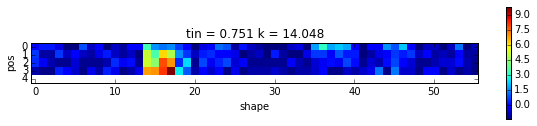

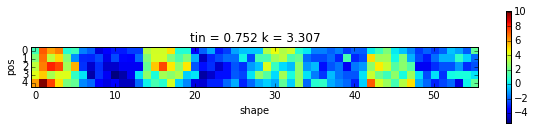

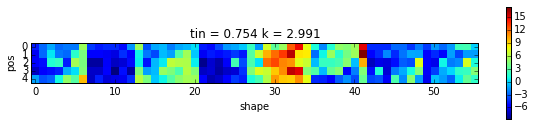

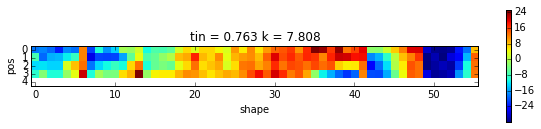

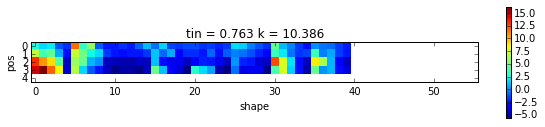

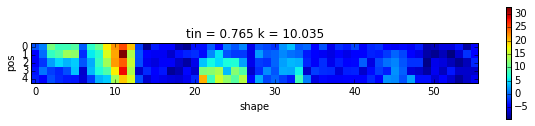

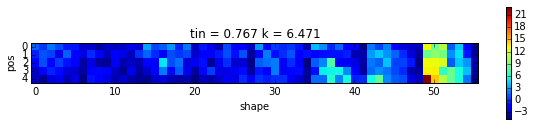

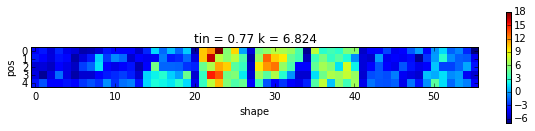

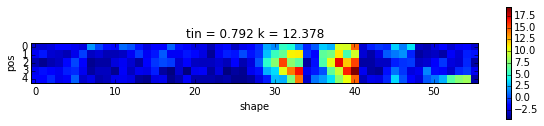

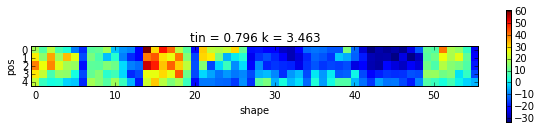

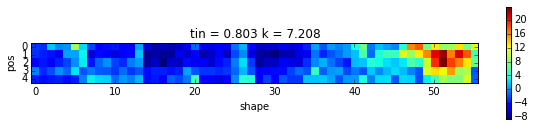

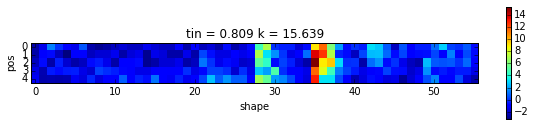

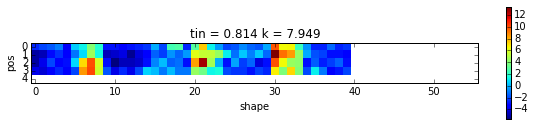

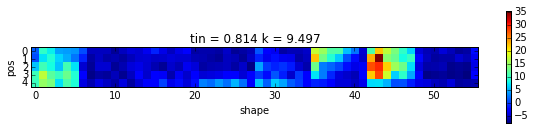

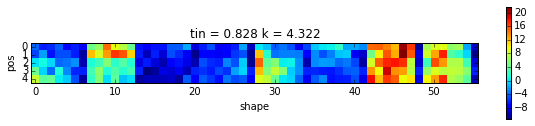

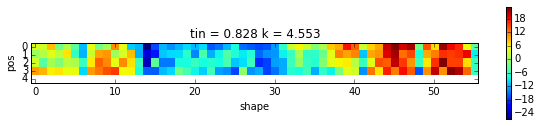

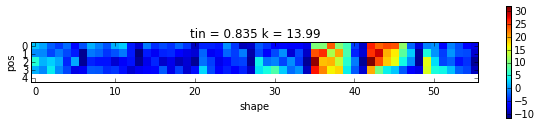

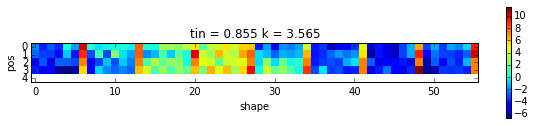

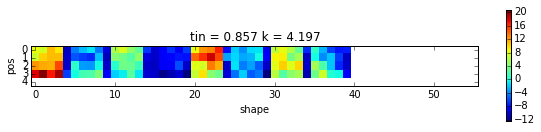

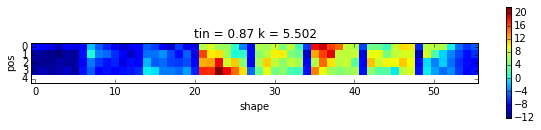

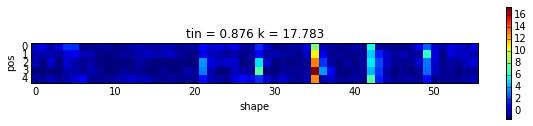

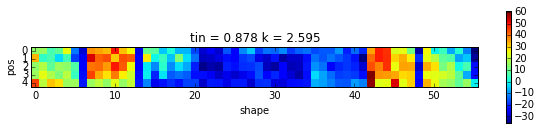

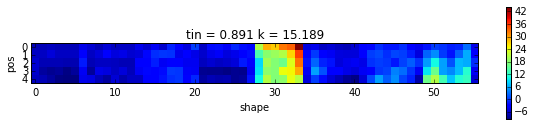

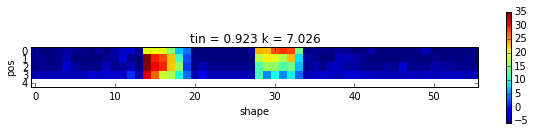

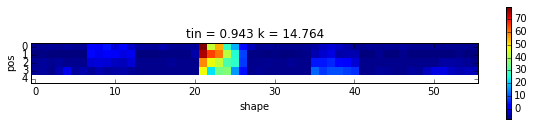

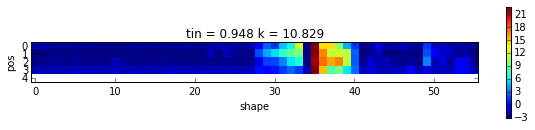

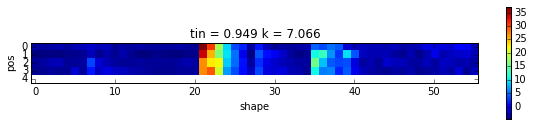

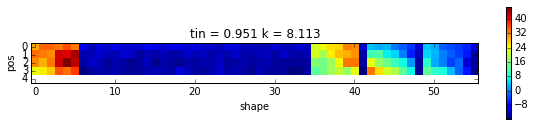

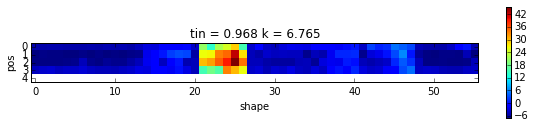

In [155]:
for ti_in in np.argsort(tin_f_maxrf):
    plt.figure(figsize=(10,2))
    plt.imshow(v4[ti_in].squeeze(), interpolation='nearest')
    plt.colorbar()
    plt.title('tin = ' + str(np.round(tin_f_maxrf[ti_in],3)) + ' k = '
              + str(np.round(k[ti_in].values, 3)))
    plt.xlabel('shape')
    plt.ylabel('pos')